In [1]:
import os
import mokapot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append("..")
sys.path
import data_loader


In [2]:
def filter_data(df, prob_column='probability'):
     #drop decoy
    df = df[df["decoy"]==False]
    #sort by qvalue
    df = df.sort_values(prob_column)
    #drop duplicate scans
    df = df.drop_duplicates(subset=["scan"], keep="first") #keep highest scoring
    return df

In [3]:
def set_probablility(row):
    new_prob = 1 - row.probability
    return new_prob

Reading an PSMS file into a dataframe, turning it into LinearPsmDataSet, and running it through MokaPot

In [4]:
def make_target_col_msfragger(row):
    if row["Protein"].startswith("rev"):
        return False
    else:
        return True
    
    
#pulling only scan numbers out
def extractScanNum(row):
    return(int(row[35:40]))

In [5]:
def get_PreMokaPot_data(file):
    msf_df = data_loader.clean_msfragger(file)
    msf_df = filter_data(msf_df)
    
    #Changing the probabilities to the same scale all the other tools use 
    msf_df["Updated_probability"] = msf_df.apply(set_probablility, 1)
    return msf_df

In [6]:
def get_data_for_MokaPot(file):
    msf_df = data_loader.clean_msfragger(file)
    
    msf_df["target_column"] = msf_df.apply(make_target_col_msfragger, axis = 1)
    
     #Extracting scan number from file number
    msf_df['scan'] =msf_df['scan'].apply(extractScanNum) 
    
    msf_df = msf_df.rename(columns = {"scan": "ScanNr"})
    
    #Dropping columns that are not numerical values
    msf_df = msf_df.drop(columns = {'Peptide', 'Spectrum File','Modified Peptide','Assigned Modifications',
       'Observed Modifications', 'Gene', 'Mapped Genes', 'Mapped Proteins','Protein Description', 
       'Is Unique','Protein', 'Protein ID', 'Entry Name', 'Protein Description', 'temp_peptide', 'decoy'})
    
    #Changing the probabilities to the same scale all the other tools use. Dropping the old probability column
    msf_df["Updated_probability"] = msf_df.apply(set_probablility, 1)
    msf_df = msf_df.drop(columns = 'probability')
    
    return msf_df
    
    

In [7]:
def plot_qvalues(df, level="psms", threshold=0.01, ax=None, **kwargs):
    qvals = df["probability"]

    ax = plot_qvalues(qvals, threshold=threshold, ax=ax, **kwargs)
    ax.set_xlabel("q-value")
    ax.set_ylabel(f"Accepted {self._level_labs[level]}")

    return ax

In [8]:
def plot_qvalues(qvalues, threshold=0.01, ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()

    # Calculate cumulative targets at each q-value
    qvals = pd.Series(qvalues, name="qvalue")
    qvals = qvals.sort_values(ascending=True).to_frame()
    qvals["target"] = 1
    qvals["num"] = qvals["target"].cumsum()
    qvals = qvals.groupby(["qvalue"]).max().reset_index()
    qvals = qvals[["qvalue", "num"]]

    zero = pd.DataFrame({"qvalue": qvals["qvalue"][0], "num": 0}, index=[-1])
    qvals = pd.concat([zero, qvals], sort=True).reset_index(drop=True)

    xmargin = threshold * 0.05
    ymax = qvals.num[qvals["qvalue"] <= (threshold + xmargin)].max()
    ymargin = ymax * 0.05

    # Set margins
    curr_ylims = ax.get_ylim()
    if curr_ylims[1] < ymax + ymargin:
        ax.set_ylim(0 - ymargin, ymax + ymargin)

    ax.set_xlim(0 - xmargin, threshold + xmargin)
    ax.set_xlabel("q-value")
    ax.set_ylabel(f"Discoveries")

    ax.step(qvals["qvalue"].values, qvals.num.values, where="post", **kwargs)

    return ax

In [9]:
#Read all the files into a list here
file_names = ["2ng"]

for file in file_names:
    print(file)

2ng


In [10]:
for file in file_names:
    msf_cleaned_df = get_PreMokaPot_data(file)
    msf_df = get_data_for_MokaPot(file)
    msf_for_MP = mokapot.dataset.LinearPsmDataset(msf_df, target_column = "target_column", spectrum_columns = "ScanNr", 
                                                 peptide_column = "peptide", protein_column=None, 
                                                 group_column=None, feature_columns=None, copy_data=True)

    results, models = mokapot.brew(msf_for_MP)

    results_df = results.psms
    results_df.to_csv("MokaPot_Output/msfragger_" + file + ".csv")

In [11]:
results

A mokapot.confidence.LinearConfidence object:
	- PSMs at q<=0.01: 13487
	- Peptides at q<=0.01: 11945

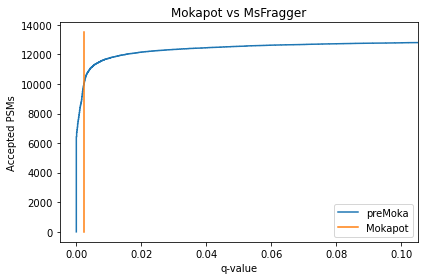

In [12]:
plot_qvalues(msf_cleaned_df["Updated_probability"], label="Pre-mokapot")
plt.title("Mokapot vs MsFragger")
results.plot_qvalues(label="mokapot")
plt.legend(["preMoka", "Mokapot"])

plt.tight_layout()

plt.show()

In [13]:
print("The number of PSMs found at or above 0.01: ") 
      
print("\t" + "MsFragger: " + str(len(msf_cleaned_df[msf_cleaned_df['probability'] >= 0.99])))

print("\t" + "MsFragger: " + str(len(msf_cleaned_df[msf_cleaned_df['Updated_probability'] <= 0.01])))

print("\t""MsFragger and MokaPot: " + str(len(results.psms[results.psms['mokapot q-value'] <= 0.01])))

The number of PSMs found at or above 0.01: 
	MsFragger: 11740
	MsFragger: 11733
	MsFragger and MokaPot: 13487
